In [1]:
## import dependencies
%matplotlib inline
import cv2
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

os.chdir(r"D:\git-repos\mluerig\lecture_clustering_pattern_rec_herbaria")
from utils import extract_features, resize_with_pad

# Computer vision

In this notebook we will prepare a small dataset by extracting individual leaves from batch scans and thereby explore the basics of computer vision (CV).

## Thresholding images 

Signal processing is a classic field of , the automatic extraction of meaningful information from images. Thresholding is a simple yet effective type of image segmentation technique used in signal processing. It involves converting a grayscale image into a binary image, where the pixels in the image are set to black or white based on a threshold value. 

This method is particularly useful in separating foreground from the background, simplifying the image analysis. In the context of biological imaging, thresholding can be crucial for tasks such as isolating regions of interest, like individual leaves in scans of plants. 

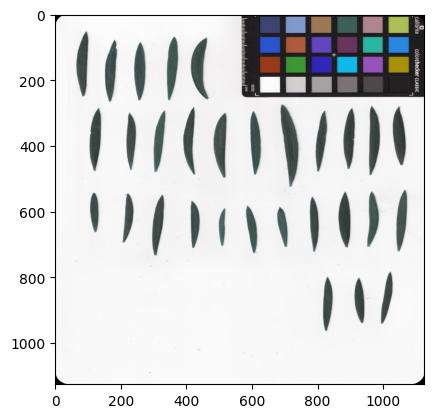

In [2]:
image_path = r'data\eucalyptus_example.png'
img = cv2.imread(image_path)
plt.imshow(img)

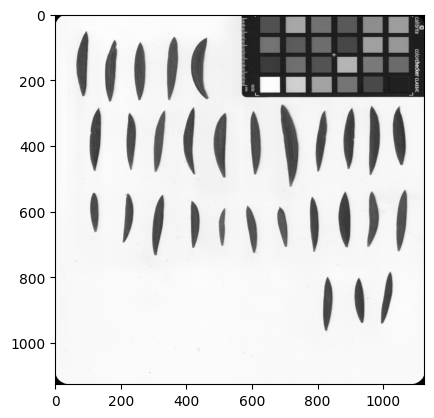

In [3]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

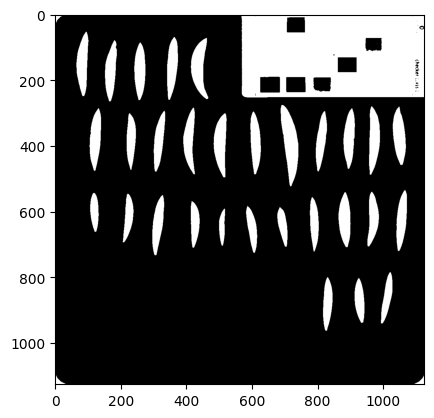

In [11]:
blurred = cv2.GaussianBlur(gray,(5,5),0)
ret, thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')

[[ 1  1  1 ...  2  2  2]
 [ 1  1  1 ...  2  2  2]
 [ 1  1  1 ...  2  2  2]
 ...
 [36 36 36 ... 37 37 37]
 [36 36 36 ... 37 37 37]
 [36 36 36 ... 37 37 37]]


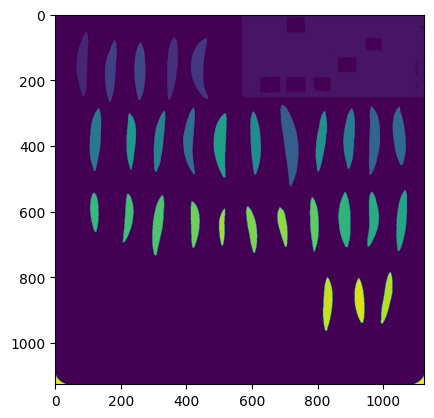

In [12]:
# Marker labelling
ret, markers = cv2.connectedComponents(thresh)
plt.imshow(markers)
print(markers)

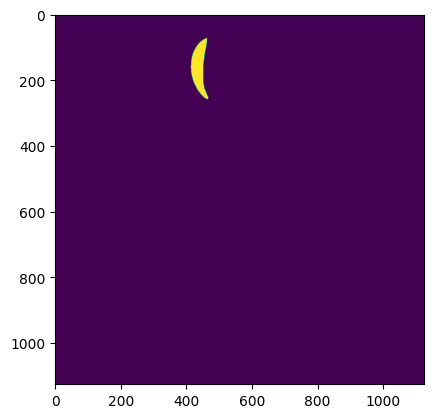

In [13]:
mask = np.zeros(markers.shape, dtype=np.uint8)
mask[markers == 6]=255
plt.imshow(mask)

413 73 53 186


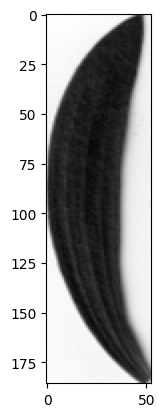

In [14]:
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x, y, w, h = cv2.boundingRect(contours[0])
plt.imshow(gray[y:y+h, x:x+w], cmap="gray")
print(x,y,w,h)

## Shape and texture traits (features)

**Shape traits** are calculated using the contour coordinates of segmented images - e.g., area, perimeter length, and circularity. Spatial moments include information about on object's centroid, orientation, and scale. There are three types of spatial moments:

- Spatial (Raw) Moments: These are directly calculated from the object's coordinates, describing its shape
- Central Moments: Deviations from the mean, variance and skewness of the centroid.
- Normalized Moments (Also known as Hu Moments): derivatives of central moments - scale, translation and rotation invariant.

**Texture traits**, derived from analyzing all pixels within the contours, encompass features like color distribution, contrast, and specific visual patterns, facilitating detailed assessments of species variation and environmental adaptation. Texture moments resemble the statistical moments of a distribution: mean intensities of all pixels, as well as their variance, skewness and kurtosis. Additionally, there are some types of higher level features, such as GLCM and GLDM:

- GLCM (Gray Level Co-occurrence Matrix): A statistical method that analyzes texture by calculating the frequency of co-occurring pixel values at a specified spatial relationship within an image to derive metrics like contrast and homogeneity.
- GLDM (Gray Level Difference Matrix): A technique that evaluates texture by examining the probability distributions of gray level differences between pairs of pixels, allowing the calculation of texture descriptors such as contrast.

## A note on invariances

It is important to be aware of the fact that some features can change depending on an image's orientation, or the location and rotation of the object it contains. So chose the features you would like to extract carefully!

- Translation Invariance: Maintains consistency when objects move within an image. Achieved by normalizing to a central point for shape or analyzing location-independent patterns for texture.
- Rotation Invariance: Ensures consistent feature identification regardless of object orientation, using methods like circularity for shape or rotation-invariant filters for texture.
- Scaling Invariance: Features remain consistent despite object size changes, through normalization of feature vectors or scale-independent abstraction techniques.
- Illumination Invariance: Addresses lighting variations by adjusting image lighting conditions or using features less sensitive to illumination changes, such as edge orientation.


## Let's extract some traits! 

We'll extract some basic features from our leaves: area, maximum diameter, and circularity for shape, and the first for moments of distribution of pixel values (mean, variance, skewness, kurtosis). 

In [15]:
contour = contours[0]

area = cv2.contourArea(contour)
diameter = int(cv2.minEnclosingCircle(contour)[1] * 2)
circularity = (4 * np.pi * area) / (cv2.arcLength(contour, True) ** 2)

print(area, diameter, circularity)

5240.5 185 0.35648181552387154


In [16]:
roi = gray[y:y+h, x:x+w]
roi_mask = np.logical_not(mask[y:y+h, x:x+w])
masked_array = np.ma.masked_array(roi, mask=roi_mask)

mean = np.ma.mean(masked_array)
variance = np.ma.var(masked_array)
skewness = stats.skew(masked_array.compressed())
kurtosis = stats.kurtosis(masked_array.compressed()) 

print(mean, variance, skewness, kurtosis)

80.75980121479846 279.87880371531605 2.567443665405688 7.554027857470693


## Final pipeline

Wrapping it all up in a single pipeline - segmentation and trait extraction, it would look like this:

In [17]:
## prepare variables
count = 0 
results = dict()
image_name = os.path.basename(image_path)
roi_dir = r"data/rois"
os.makedirs(roi_dir, exist_ok=True)

# iterate over the instances and isolate the leavess
for i in range(1,markers.max()+1):
    
    # create a mask for the current marker
    mask = np.zeros(markers.shape, dtype=np.uint8)
    mask[markers == i] = 255

    # find the contours of the mask
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])

    if w < 150 and h > 100:

        ## advance counter
        count += 1

        ## get contour, ROI, and ROI-mask
        contour = contours[0]
        roi = gray[y:y+h, x:x+w]
        roi_mask = mask[y:y+h, x:x+w]

        ## extract features and save to dictionary
        results[count] = extract_features(contour, gray, mask)

        ## save a resized and padded version of the ROI
        image = resize_with_pad(roi, (512, 512))
        cv2.imwrite(os.path.join(roi_dir, f'{image_name}_{count}.jpg'), image)


In [18]:
df = pd.DataFrame.from_dict(results, orient="index")
df.columns = ['Area', 'Diameter', 'Circularity', 'Mean', 'Variance', 'Skewness', 'Kurtosis']
df

,Area,Diameter,Circularity,Mean,Variance,Skewness,Kurtosis
1,4578.0,195,0.322789,232.190630,387.046051,-2.026558,3.576954
2,4275.5,190,0.320493,231.206107,449.622733,-1.992432,3.264739
3,5240.5,185,0.356482,235.509831,280.032954,-2.482320,5.973553
4,4224.0,185,0.326840,235.437391,480.217183,-1.792273,2.401954
5,4211.5,174,0.369871,231.631646,604.768223,-1.611584,1.529428
6,7431.0,248,0.318556,233.812084,304.712674,-2.574422,6.125635
7,4743.0,207,0.302776,230.500785,404.885269,-1.677285,1.932982
8,4611.5,177,0.380869,234.380155,390.376531,-2.114596,3.763348
9,4169.5,202,0.269961,234.311179,379.859200,-2.338158,5.053224
10,4418.5,189,0.330429,234.378127,440.456824,-2.079377,3.629974
